In [19]:
import argparse, sys, shutil, glob, os
from pathlib import Path
from itertools import combinations
from datetime import datetime

import numpy as np
import pandas as pd
import arviz as az
# from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.special import expit, logit
from tqdm import tqdm
import pickle
# import pystan
# import stan


# 1) Load your saved .nc

In [ ]:
import arviz as az
from pathlib import Path

nc_path = "stan_out/rlddm_single_subject-20250924_182849.nc"  # <- your file
idata = az.from_netcdf(nc_path)


# 2) Quick sanity: R-hat / ESS

In [21]:
az.summary(idata, var_names=["alpha","a","t0","scaler"], hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.038,0.034,0.006,0.073,0.001,0.004,1239.0,614.0,1.0
a,1.208,0.010,1.189,1.227,0.000,0.000,2187.0,2614.0,1.0
t0,0.317,0.004,0.310,0.324,0.000,0.000,2168.0,2022.0,1.0
scaler,0.157,0.074,0.031,0.294,0.002,0.002,1379.0,692.0,1.0


# 3) Correlations among parameters (all draws)

In [22]:
post = az.extract(idata, var_names=["alpha","a","t0","scaler"], combined=True).to_pandas()
post.corr()


,alpha,a,t0,scaler,chain,draw
alpha,1.000000,0.157367,0.001499,-0.528789,-6.290373e-03,-3.282611e-02
a,0.157367,1.000000,-0.168890,-0.067250,-1.563202e-02,-8.993840e-03
t0,0.001499,-0.168890,1.000000,0.020754,7.756257e-03,-1.468530e-02
scaler,-0.528789,-0.067250,0.020754,1.000000,7.784854e-03,-1.759881e-02
chain,-0.006290,-0.015632,0.007756,0.007785,1.000000e+00,-1.756362e-16
draw,-0.032826,-0.008994,-0.014685,-0.017599,-1.756362e-16,1.000000e+00


# 4) Correlations with divergent draws removed

In [23]:
# boolean mask of divergent transitions aligned to combined draws
div = idata.sample_stats["diverging"].stack(sample=("chain","draw")).values.astype(bool)
post_ok = post[~div]
post_ok.corr()


,alpha,a,t0,scaler,chain,draw
alpha,1.000000,0.164761,-0.005220,-0.534418,-0.023369,-0.027885
a,0.164761,1.000000,-0.169113,-0.066513,-0.013106,-0.005499
t0,-0.005220,-0.169113,1.000000,0.026386,0.006634,-0.017734
scaler,-0.534418,-0.066513,0.026386,1.000000,0.013618,-0.019458
chain,-0.023369,-0.013106,0.006634,0.013618,1.000000,0.000259
draw,-0.027885,-0.005499,-0.017734,-0.019458,0.000259,1.000000


# 5) Helpful plots (optional)

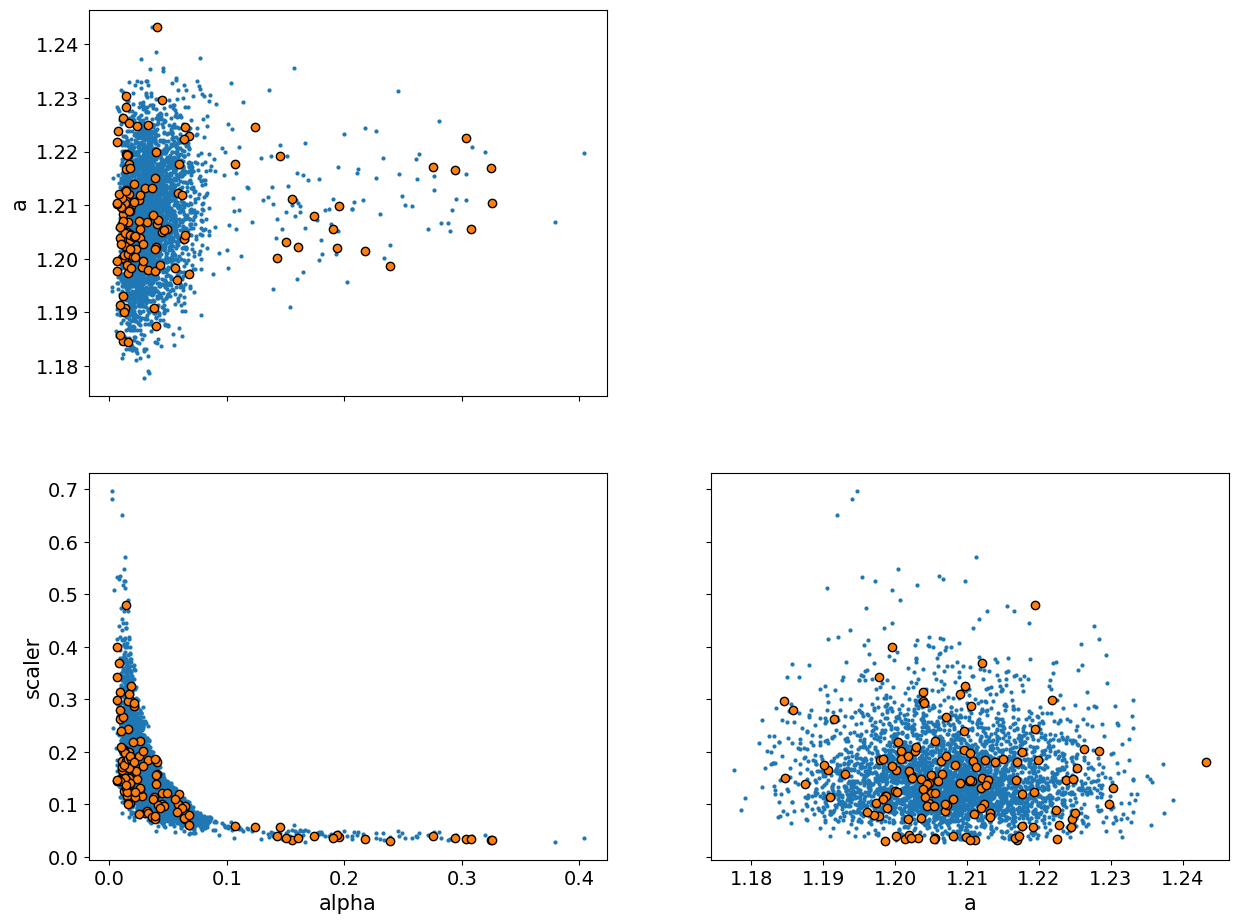

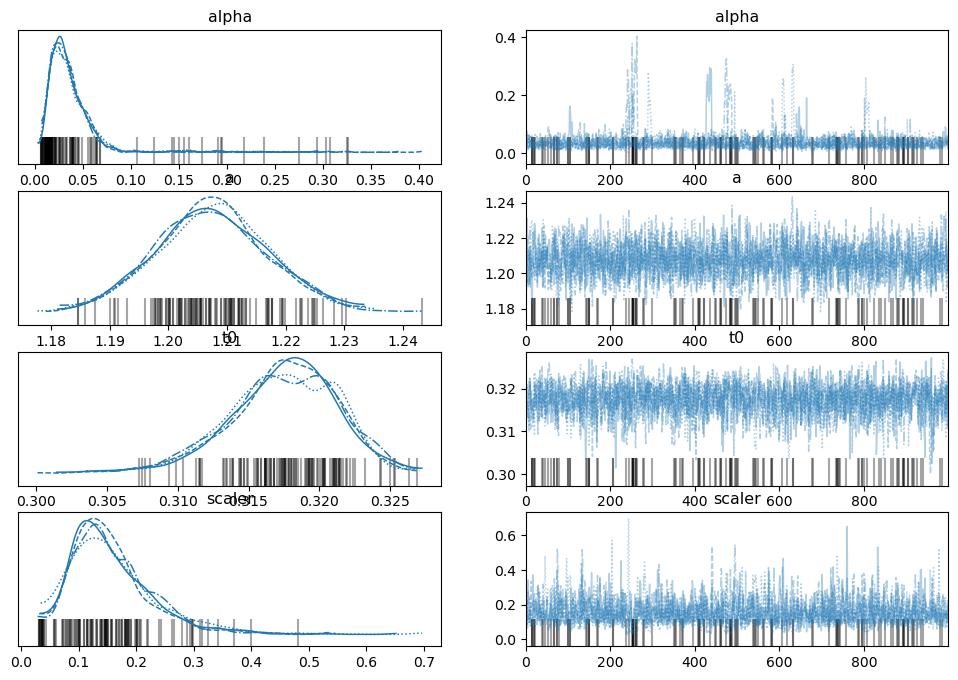

In [24]:
az.plot_pair(idata, var_names=["alpha","a","scaler"], kind="scatter", divergences=True);
az.plot_trace(idata, var_names=["alpha","a","t0","scaler"]);


# 6) Count divergences, max treedepth, etc.

In [25]:
print(int(idata.sample_stats["diverging"].sum()),
int((idata.sample_stats["tree_depth"] == idata.sample_stats["tree_depth"].max()).sum()))


126 209
